#Errors in serial dilution: How can dispensing technology impact assay data?

####[Sonya M. Hanson and John D. Chodera](http://www.choderalab.org/) Computational Biology Program, Memorial Sloan Kettering Cancer Center, New York NY 10065

In a 2013 paper by Ekins et al, [Dispensing Processes Impact Apparent Biological Activity as Determined by Computational and Statistical Analyses. PLoS ONE 8(5): e62325, 2013](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0062325), a surprisingly large discrepancy in IC50 assay results is noted between the assay performed using a **Tecan Genesis** liquid handling workstation compared with a **LabCyte Echo** acoustic dispensing unit.

> *It would appear that tip-based dispensing is producing erroneous data based on our and other analyses which we see here reflected in the models and initial lack of correlations with molecular properties.*

This discrepancy was so large and so surprising that it was quickly picked up and discussed at length by numerous industry blogs, most notabley [In the Pipeline by Derek Lowe](http://pipeline.corante.com/archives/2013/05/03/drug_assay_numbers_all_over_the_place.php), which called the report a "truly disturbing paper".  Speculation abounded as to the precise cause: including sticky compounds, plastic leaching out of pipette tips, colloidal aggregation, miscalibrated pipettes, and sloppy experiments.  But could a simple physical process rooted in the intrinsic variability in the assay explain this difference?

In a biochemical or cell-based assay to determine the potency of a compound of interest, solutions of the compound at several concentrations are prepared and the the assay readout at a number of these concentrations can be fit to yield the $K_i$, IC50, or EC50 (depending on the assay configuration).

With a traditional manual assay or liquid handling workstation (such as the **Tecan Genesis**), the most straightforward approach to preparing a number of these compound concentrations is to prepare a **serial dilution series** starting from an original compound stock solution (often 10 mM stock in DMSO).  In a serial dilution, a volume $V_0$ of one solution is transferred into the next well and diluted with another volume $V_1$ of diluent, allowing a series of solutions spanning orders of magnitude in compound concentration to be prepared in a serial manner.

![alt text](img/serial.png "serial.png")

The **LabCyte Echo**, on the other hand, uses a direct dispensing technology to transfer a programmed volume (from 2.5 nL to microliters) directly into the assay wells, allowing a dilution series over several orders of magnitude in concentration to be created directly without the need for serial dilution.

![alt text](img/direct.png "direct.png")

While the Ekins paper explores the impact assay discrepancies has on QSAR models parameterized to the data, we focus here on the origin of the differences in assay results, and show how a simple model that captures the errors introduced at each step of the assay can lead us to identify the culprit behind the large discrepancy between the two assay configurations.  Understanding the origin of this discrepancy---which ends up being a source of bias in one of the assay configurations---can allow us to anticipate assay issues ahead of time, take steps to mitigate them, or even to correct for them after the fact.

Here, we introduce a simple kind of assay modeling in **this IPython notebook** that computational and experimental chemists alike can employ, as a tool that can easily be used to model and understand sources of uncertainty and  biases inherent in any experimental assay.  This kind of modeling could be used, for example, during assay development to ensure that the assay configuration will meet the dynamic range and accuracy needed for the assay, or it could be used after the fact by assay data consumers to understand the expected uncertainty and bias in the experimental dataset.

### 0. First we need to define our assay configuration.

In [1]:
# import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
from scipy.interpolate import interp1d
%pylab inline
sns.set(style='white')
sns.set_context('talk')

Populating the interactive namespace from numpy and matplotlib


Our general assay configuration follows the description given in [2] (the source of the data used in Ekins et al.).  We assume that an 8-point dilution series was generated for use in the assay.  Suppose we start with an initial concentration of 10 mM in DMSO stock, and then serially dilute two fold to create final dilution volumes of 100 uL.

> [2] Bernard Christophe Barlaam, Richard Ducray. 2,4-diamino-pyrimidine derivatives. US Patent document WO 2009010794 A1

***JDC: NOTE THAT THEY PROBABLY DIDN'T START WITH THE FIRST DILUTION BEING 5 mM, SNCE THIS IS WAY TOO HIGH FOR SOLUBILITY.  WE NEED TO FIND A "REASONABLE" INITIAL CONCENTRATION FOR THE FIRST DILUTION. I THINK THE MAX CONCENTRATION FOR ACOUSTIC DISPENSING WAS 10 mM/100 = 100 uM, SO LET'S TRY THIS***

#<span style="color:blue">insert figure here</span>
***[JDC: which figure?]***

Define number of points in dilution series:

In [2]:
ndilutions = 8

Define total volume per well as 100 µL:

In [3]:
V0 = 100e-6

Define stock concentration as 10 mM:

In [4]:
C0 = 10e-3

Define specific parameters of the dilution series (transferring 50 µL into 50 µL buffer at each step):

In [5]:
Vtransfer = 50e-6
Vbuffer = 50e-6

Define dilution series function:

In [6]:
def dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions):
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    concentrations = numpy.zeros([ndilutions], numpy.float64)
    volumes = numpy.zeros([ndilutions], numpy.float64)
    concentrations[0] = C0
    volumes[0] = V0
    
    # and Vbuffer as initial volume for all but first.
    for n in range(1,ndilutions):
        volumes[n] = Vbuffer
        
    # Create dilution series.
    for n in range(1,ndilutions):
        concentrations[n] = concentrations[n-1] * Vtransfer / (Vtransfer + Vbuffer)
        volumes[n] += Vtransfer
        volumes[n-1] -= Vtransfer
        
    # Remove Vtransfer from last.
    volumes[ndilutions-1] -= Vtransfer
    
    return [volumes, concentrations]

In [7]:
[ideal_volumes, ideal_concentrations] = dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions)

In [8]:
print "Thus we now have an %s part dilution series from %s M to %s M." % (ndilutions, C0, ideal_concentrations[-1])

Thus we now have an 8 part dilution series from 0.01 M to 7.8125e-05 M.


Let's plot it!

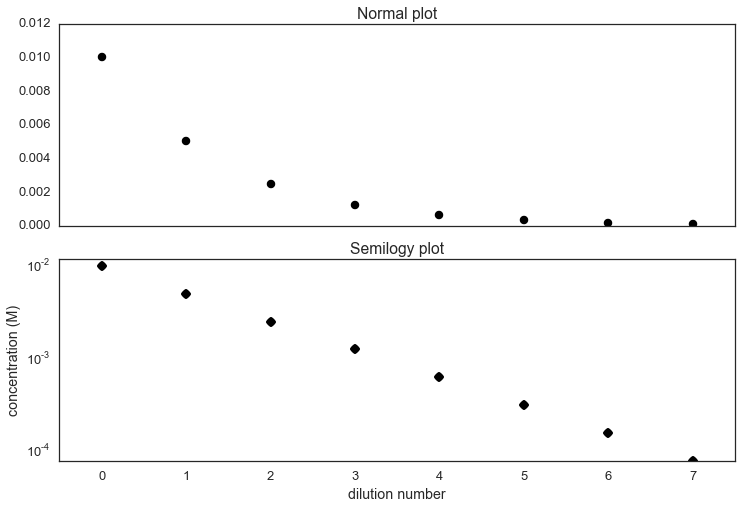

In [9]:
f, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.scatter(range(ndilutions), ideal_concentrations, lw=4)
ax1.set_title("Normal plot")
ax2.semilogy(range(ndilutions), ideal_concentrations,'ko')
ax2.set_title("Semilogy plot")
plt.xlabel('dilution number')
plt.ylabel('concentration (M)')
ax1.axis([- 0.5, ndilutions - 0.5, 0.0, C0 * 1.2])
ax2.axis([- 0.5, ndilutions - 0.5, 0.0, C0 * 1.2])
f.tight_layout()

First we'll model how a human or a liquid-handling robot does a serial dilution, then we'll model how direct dispense technology does for the same dilution series.

### 1. Dilution and dispensing by a liquid-handling robot.

Real liquid-handling robots can't transfer the specified volume exactly. Each transfer operation has some (a) inaccuracy (modeled as a constant bias factor for all dispensing operations) and (b) imprecision (random error associated with each volume transfer). We'll ignore other contributions to error, such as compound stickiness, insolubility, etc.

Suppose we generate this dilution series using a Tecan Genesis robot used in the assay.

Published specs for imprecision for the Genesis are available:

[imprecision data for Tecan Genesis](http://www.frankshospitalworkshop.com/equipment/documents/automated_analyzer/user_manuals/Tecan%20Genesis%20RMP%20-%20User%20manual.pdf)

Specs, however, for inaccuracy were not available (the Genesis has actually not been in production for some time now, note our sorta sketchy link above, too), so we'll use similar inaccuracy data for the Beckman NX/FX span-8 instead:

[inaccuracy/imprecision data for Biomek NX/FX](https://www.beckmancoulter.com/wsrportal/bibliography?docname=BR-10150B.pdf)


#<span style="color:blue">insert chart from link here</span>

Define pipetting error function for the genesis:

In [10]:
def tecan_genesis_pipetting_model(volume):
    # Imprecision from Tecan Genesis manual.
    # Inaccuracy estimated from Beckman Biomek NX/FX span-8.
    
    imprecision_function = interp1d(
        [1.5e-6,100e-6], # Volume Range
        [0.03,0.005]) # published imprecision for Tecan Genesis
    inaccuracy_function = interp1d(
        [0.5e-6, 1e-6, 100e-6], # Volume Range
        [0.05, 0.03, 0.03]) # published inaccuracy for Beckman NX/FX span-8
    
    return [inaccuracy_function(volume), imprecision_function(volume)]    

Just for reference, this is what the ideal pipetting model looks like in comparison:

In [11]:
def ideal_pipetting_model(volume):

    imprecision_function = interp1d(
        [0,0],
        [0.03,0.005]) 
    inaccuracy_function = interp1d(
        [0, 0, 0],
        [0.05, 0.03, 0.03]) 
    
    return [inaccuracy_function(volume), imprecision_function(volume)]    

#<span style="color:blue">Add better description of what is changing.</span>

Now we'll apply this error to our dilution series:

In [12]:
# define ROBOT_dilution_series function
def ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, pipetting_model):
    
    # use pipetting error function
    [transfer_inaccuracy, transfer_imprecision] = pipetting_model(Vtransfer)    
            
    # define (b) imprecision of volume transfer operations (including initial volumes)
    transfer_bias = transfer_inaccuracy * normal()
    
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    actual_concentrations = numpy.zeros([ndilutions], numpy.float64)
    actual_volumes = numpy.zeros([ndilutions], numpy.float64)
    actual_concentrations[0] = C0
    actual_volumes[0] = V0
    
    # and Vbuffer as initial volume for all but first.
    Vbuffer_actual = Vbuffer * ((1+transfer_bias) + transfer_imprecision*normal())
    for n in range(1,ndilutions):
        actual_volumes[n] = Vbuffer_actual
    
    # Create dilution series.
    for n in range(1,ndilutions):
        Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
        actual_concentrations[n] = \
            actual_concentrations[n-1] * Vtransfer_actual / (Vtransfer_actual + Vbuffer_actual)
        actual_volumes[n] += Vtransfer_actual
        actual_volumes[n-1] -= Vtransfer_actual
    Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
    
    # Remove Vtransfer from last.
    actual_volumes[ndilutions-1] -= Vtransfer_actual
    
    return [actual_volumes, actual_concentrations]

In [13]:
[actual_volumes, actual_concentrations] = \
    ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)

Let's plot it!

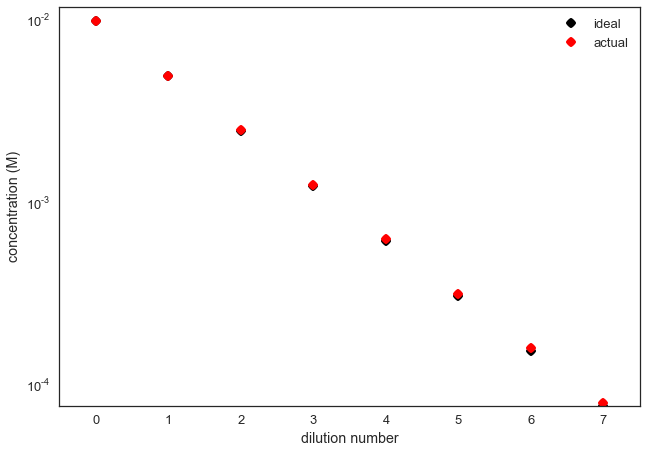

In [14]:
plt.semilogy(range(ndilutions), ideal_concentrations, 'ko', range(ndilutions), actual_concentrations, 'ro');
plt.xlabel('dilution number');
plt.ylabel('concentration (M)');
plt.legend(['ideal','actual']);
plt.axis([-0.5, ndilutions - 0.5, 0.0, C0 * 1.2]);

What if we plot the relative errors in concentration, volume, and total quantity of compound per well?

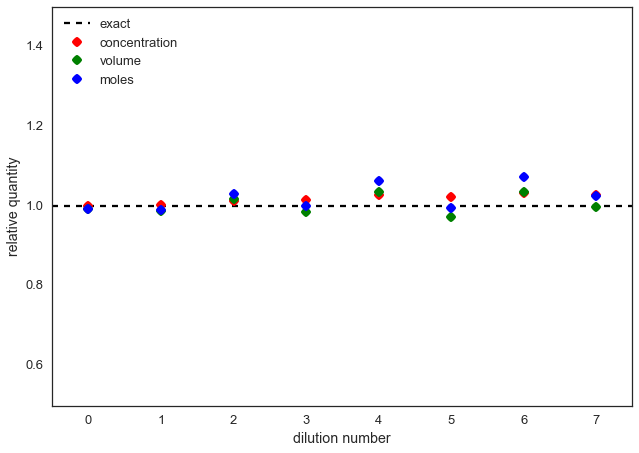

In [15]:
plt.plot([-0.5, ndilutions], [1, 1], 'k--');
plt.plot(range(ndilutions), actual_concentrations / ideal_concentrations, 'ro', \
         range(ndilutions), actual_volumes / ideal_volumes, 'go', \
         range(ndilutions), (actual_volumes*actual_concentrations)/(ideal_volumes*ideal_concentrations), 'bo');
plt.legend(['exact', 'concentration', 'volume', 'moles'], loc='upper left');
plt.axis([-0.5, ndilutions - 0.5, 0.5, 1.5]);
plt.ylabel('relative quantity');
plt.xlabel('dilution number');

This is kind of all over the place, with no obvious trend, but what if we repeat the experiment many times? Then we can estimate the **coefficient of variation (CV)** for each dilution number.

Let's repeat the experiment 5000 times:

In [16]:
nreplicates = 5000

actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)

for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = \
        ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
        
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate

Now let's use this to compute the CV, using numpy.std, which calculates the standard deviation:

In [17]:
volumes_cv = (actual_volumes_n / ideal_volumes).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).std(0)

And let's plot it!

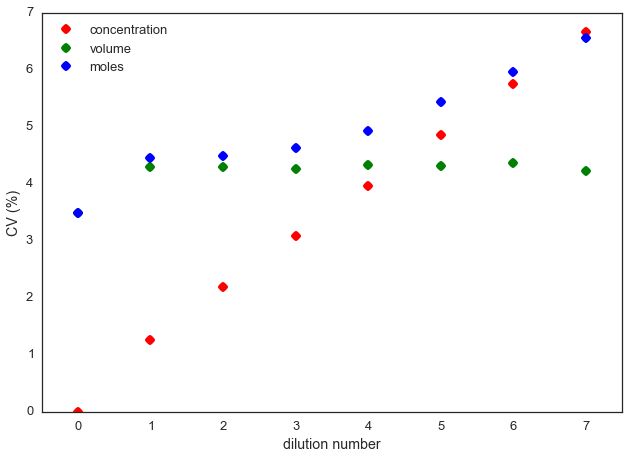

In [18]:
plt.plot(range(ndilutions), concentrations_cv*100, 'ro', \
         range(ndilutions), volumes_cv*100, 'go', \
         range(ndilutions), quantity_cv*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('CV (%)')
plt.xlim([-0.5, ndilutions - 0.5])
plt.legend(['concentration', 'volume', 'moles'], loc='upper left')

So these are the errors we're getting just by looking at inaccuracy and imprecision. Notice how the concentration error creeps up to almost 20% in the last sample?

But is there a bias at all as a result of this?

Let's look at the mean of all these values for this 5000 replicate test.

[-0.5, 7.5, -100, 100]

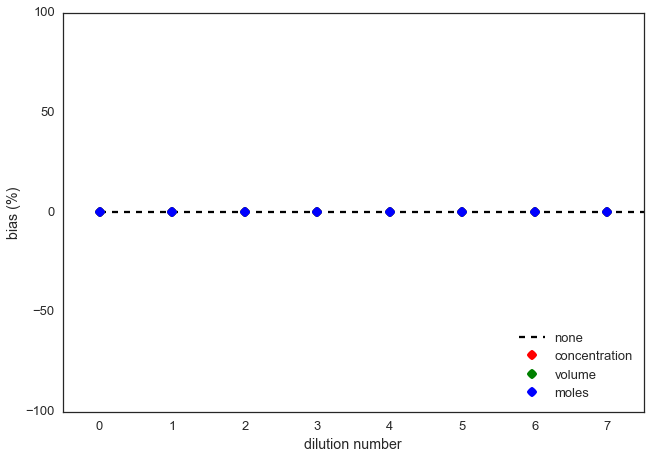

In [19]:
# Compute relative bias.
volumes_bias = (actual_volumes_n / ideal_volumes).mean(0) - 1
concentrations_bias = (actual_concentrations_n / ideal_concentrations).mean(0) - 1
quantity_bias = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).mean(0)- 1

#Let's define DILUTIONS to make plotting easier.
dilutions = numpy.arange(ndilutions)

# Plot relative biases.
plt.plot([0, ndilutions], [0, 0], 'k--', dilutions, concentrations_bias*100, 'ro', \
     dilutions, volumes_bias*100, 'go', dilutions, quantity_bias*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('bias (%)')
plt.legend(['none','concentration', 'volume', 'moles'], loc='lower right')
plt.axis([-0.5, ndilutions - 0.5, -100, 100])

Despite some creep in the eror, it doesn't seem like there's a tremendous bias.

###But wait!

###We still have one more source of error to add!

In an interesting paper by Dong et al, [The use of a dual dye photometric calibration method to identify possible sample dilution from an automated multichannel liquid-handling system. J. Lab. Autom. 11(2): 2006](http://dx.doi.org/10.1016/j.jala.2006.02.005), they reveal that the system liquid on the inside of the steel fixed tips of the Tecan Genesis can result in significant dilution errors.

In [20]:
# define dilution_function
volume = numpy.array([20, 200]) * 1e-6 
dilution_effect = numpy.array([-0.0630, -0.0496])

dilution_function = interp1d(volume, dilution_effect)
    

In [21]:
# define DILUTE_ROBOT_dilution_series function
def DILUTE_ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, pipetting_model):
    
    # use pipetting error function
    [transfer_inaccuracy, transfer_imprecision] = pipetting_model(Vtransfer)    
            
    # define (b) imprecision of volume transfer operations (including initial volumes)
    transfer_bias = transfer_inaccuracy * normal()
    
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    actual_concentrations = numpy.zeros([ndilutions], numpy.float64)
    actual_volumes = numpy.zeros([ndilutions], numpy.float64)
    actual_concentrations[0] = C0
    actual_volumes[0] = V0
    
    # and Vbuffer as initial volume for all but first.
    Vbuffer_actual = Vbuffer * ((1+transfer_bias) + transfer_imprecision*normal())
    for n in range(1,ndilutions):
        actual_volumes[n] = Vbuffer_actual
    
    # Create dilute dilution series 
    # Observe only change is in actual_concentrations[n].
    for n in range(1,ndilutions):
        Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
        actual_concentrations[n] = \
             actual_concentrations[n-1] * Vtransfer_actual / (Vtransfer_actual + Vbuffer_actual)\
             * (1+dilution_function(Vtransfer))
        actual_volumes[n] += Vtransfer_actual 
        actual_volumes[n-1] -= Vtransfer_actual
    Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
    
    #Remove Vtransfer from last.
    actual_volumes[ndilutions-1] -= Vtransfer_actual
    
    return [actual_volumes, actual_concentrations]



And repeat!

In [22]:
nreplicates = 5000

actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)

for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = DILUTE_ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate

Let's see what our CVs look like now!

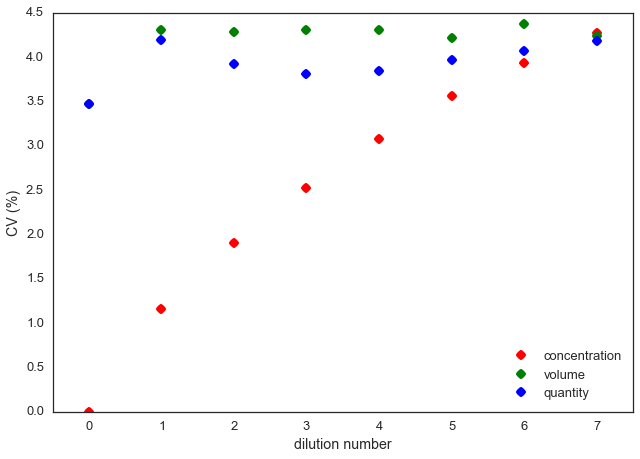

In [23]:
volumes_cv = (actual_volumes_n / ideal_volumes).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).std(0)

# Plot CVs
plt.plot(dilutions, concentrations_cv*100, 'ro', dilutions, volumes_cv*100, 'go', dilutions, quantity_cv*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('CV (%)')
plt.xlim([-0.5, ndilutions -0.5])
plt.legend(['concentration', 'volume', 'quantity'], loc='lower right')

Now, let's check the bias again.

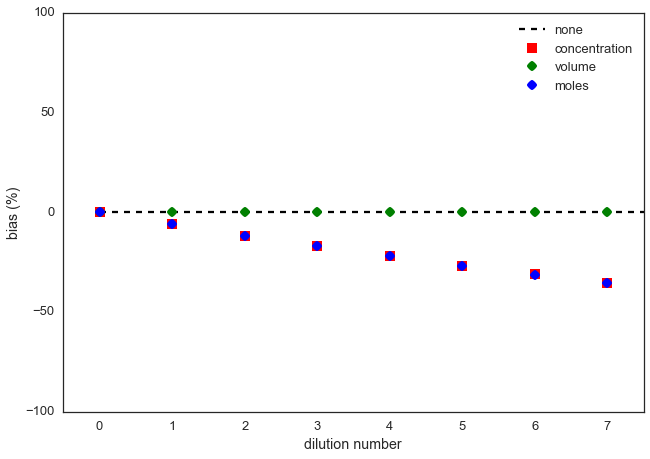

In [24]:
# Compute relative bias.
volumes_bias = (actual_volumes_n / ideal_volumes).mean(0) - 1
concentrations_bias = (actual_concentrations_n / ideal_concentrations).mean(0) - 1
quantity_bias = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).mean(0)- 1

# Plot relative biases.
plt.plot([0, ndilutions], [0, 0], 'k--', dilutions, concentrations_bias*100, 'rs',\
     dilutions, volumes_bias*100, 'go', dilutions, quantity_bias*100, 'bo');
plt.xlabel('dilution number');
plt.ylabel('bias (%)');
plt.legend(['none', 'concentration', 'volume', 'moles'], loc='upper right');
plt.axis([-0.5, ndilutions - 0.5, -100, 100]);

Definitely some bias in there now. Even though the volume error is evenly distributed, the concentration error is constantly decreasing, which means the actually quantity (moles) used is also decreasing.

### 2. Dispensing by direct dispensing with the LabCyte Echo.

What about the LabCyte Echo experiments? According to LabCyte, the Echo has an inaccuracy of 10% and a precision of 8% over the entire dispense range of 2.5 nL to 10 uL. Let's model how it dispenses directly into the assay plate with an 9-point dilution series spanning 2.5 nL to 120 nL from 10 mM stock solution.

#<span style="color:blue">insert figure here</span>

Define DMSO compound stock concentration as 10 mM:

In [25]:
C0 = 10e-3

Define assay volume as 12 uL (note that ideal assay volume here is different than the serial dilution setup):

In [26]:
assay_volume = 12e-6

Define 9-point titration (multiples of 2.5 nL):

In [27]:
dispense_volumes = 2.5e-9 * numpy.array([6, 12, 18, 24, 30, 36, 42, 48])

Define the concentrations in this titration:

In [28]:
concentrations = (C0*dispense_volumes/assay_volume)

To make sure our DMSO concentration does not vary as we vary our compound concentration, we'll always backfill up to 120 nL total DMSO:

In [29]:
backfill_volume = 120e-9

Define the mix volume as assay_volume - backfill_volume, e.g. 12 uL assay volume minus 120 uL:

In [30]:
mix_volume = assay_volume - backfill_volume

In [31]:
#ndilutions, volumes, backfill, min

Published specs for the LabCyte Echo are available:

[inaccuracy/imprecision data for LabCyte Echo](http://www.labcyte.com/sites/default/files/support_docs/Echo%205XX%20Specifications.pdf)

In [32]:
# define echo_assay_dispense function
def echo_assay_dispense(C0, mix_volume, backfill_volume, dispense_volumes):
    inaccuracy = 0.10
    imprecision = 0.08

    ndilutions = len(dispense_volumes)
    echo_volume = numpy.zeros([ndilutions], numpy.float64)
    echo_concentration = numpy.zeros([ndilutions], numpy.float64)
    bias = inaccuracy * normal()
    
    for i in range(ndilutions):
        compound_volume_intended = dispense_volumes[i]
        backfill_volume_intended = backfill_volume - compound_volume_intended
        
        compound_volume_dispensed = compound_volume_intended * ((1+bias) + imprecision*normal())
        backfill_volume_dispensed = backfill_volume_intended * ((1+bias) + imprecision*normal())
        
        echo_volume[i] = mix_volume + backfill_volume_dispensed + compound_volume_dispensed
        echo_concentration[i] = C0 * compound_volume_dispensed / echo_volume[i]

    return [echo_volume, echo_concentration]

In [33]:
[echo_volumes, echo_concentrations] = echo_assay_dispense(C0, mix_volume, backfill_volume, dispense_volumes)

Let's plot this:

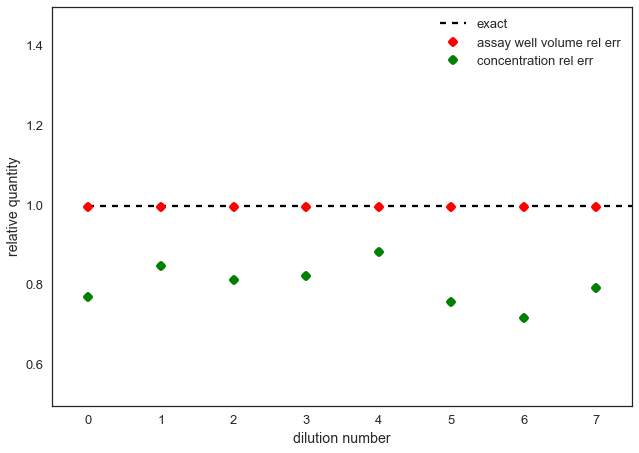

In [34]:
plt.plot([0,ndilutions], [1, 1], 'k--', range(ndilutions), echo_volumes / assay_volume,'ro',\
         range(ndilutions), echo_concentrations / concentrations, 'go');
plt.legend(['exact', 'assay well volume rel err', 'concentration rel err'], loc='upper right')
plt.axis([-0.5, ndilutions - 0.5, 0.5, 1.5])
plt.ylabel('relative quantity')
plt.xlabel('dilution number')

And repeat!

In [35]:
nreplicates = 10000

actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)

ndilutions = len(dispense_volumes)
volume_array = numpy.ones([ndilutions]) * assay_volume

for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = echo_assay_dispense(C0, mix_volume, backfill_volume, dispense_volumes)
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate
volumes_cv = (actual_volumes_n / volume_array).std(0)
concentrations_cv = (actual_concentrations_n / concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (volume_array * concentrations)).std(0)

Let's plot CVs!

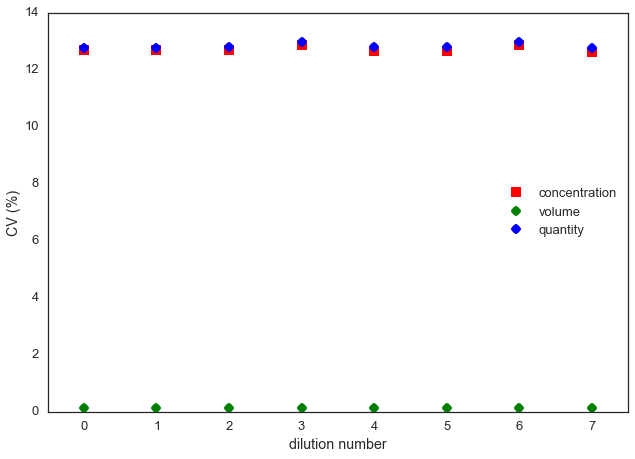

In [36]:
#Let's define DILUTIONS to make plotting easier.
dilutions = numpy.arange(ndilutions)

plt.plot(dilutions, concentrations_cv*100, 'rs', dilutions, volumes_cv*100, 'go', dilutions, quantity_cv*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('CV (%)')
plt.xlim([-0.5,ndilutions - 0.5])
plt.legend(['concentration', 'volume', 'quantity'], loc='center right')

Now let's check if there are any biases here.

[-0.5, 7.5, -100, 100]

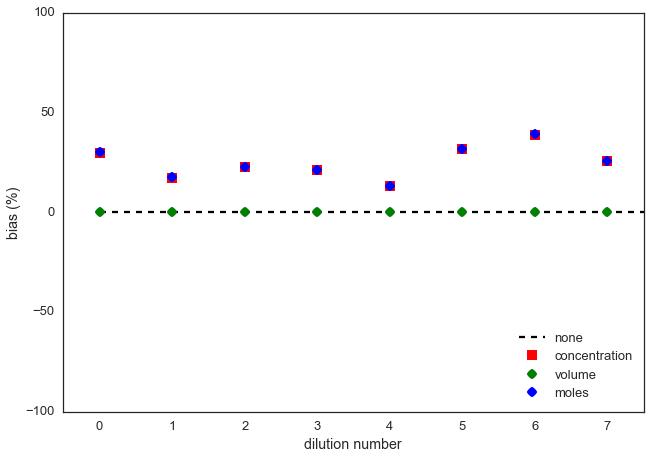

In [37]:
# Compute relative bias.
volumes_bias = (actual_volumes_n / echo_volumes).mean(0) - 1
concentrations_bias = (actual_concentrations_n / echo_concentrations).mean(0) - 1
quantity_bias = ((actual_volumes_n * actual_concentrations_n) / (echo_volumes * echo_concentrations)).mean(0)- 1

# Plot relative biases.
plt.plot([0, ndilutions], [0, 0], 'k--', dilutions, concentrations_bias*100, 'rs', \
     dilutions, volumes_bias*100, 'go', dilutions, quantity_bias*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('bias (%)')
plt.legend(['none','concentration', 'volume', 'moles'], loc='lower right')
plt.axis([-0.5, ndilutions - 0.5, -100, 100])

#<span style="color:blue">Insert comparison here of two CVs and two biases.</span>

### 3. How do IC50 estimates between these compare?

Now lets see how these errors relate to IC50 results. Let's assume EphB4 as our system, with a Km for ATP by EphB4 of 1.71 uM ([EphB4 DataSheet](http://www.proqinase.com/kinase-database/pdfs/2843.pdf)). Note that we're assuming that EphB4 obeys Michaelis-Menten kinetics here, and that V0/Vmax is what is measured.

In [38]:
Km = 1.71e-6

Let's assume true Ki for an arbitrary compound is 10 nM.

In [39]:
true_Ki = 10e-9

Let's assume a substrate concentration of 4 µM ATP.

In [40]:
substrate_concentration = 4e-6

Let's Assume 0.25 ng of ~42.4 kDa enzyme, which is ~ 6 µM.

In [41]:
enzyme_concentration = 6e-6

We will dispense 2 µL of diluted compound into an assay plate well into which 10 µL of enzyme mix has been dispense. 

Define volume of compound to be dispensed as 2 µL:

In [42]:
compound_volume = 2.0e-6

Define volume of enzyme mix into which this is dispesned as 10 µL:

In [43]:
mix_volume = 10.0e-6

Let's suppose the 10 uL of assay mix in each well was dispensed completely accurately, and contains exact concentrations of enzyme and substrate. We presume inhibition is measured by an exact read of the reaction V0/Vmax.

 The IC50 would be the interpolated point at which V0/Vmax drops to 0.5, as determined from a fit of the competitive inhibition equations to the observed V0/Vmax for the dilution series, using the ideal dilution series concentrations in the fit.

### 3A. IC50s for the Tecan Genesis

There is additional error since the imprecision at this volume is higher, so we will model that first.

We'll use our robot dilution series that includes the dilution effect.

In [44]:
[actual_volumes, actual_concentrations] = \
    DILUTE_ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)

Then make a more accurate function that takes into account the mixing volume and incorporates our *tecan_genesis_pipetting_model*.

In [45]:
def robot_dispense(compound_volume, mix_volume, compound_concentrations, pipetting_model):
    [compound_inaccuracy, compound_imprecision] = pipetting_model(compound_volume)
    [mix_inaccuracy, mix_imprecision] = pipetting_model(mix_volume)
    
    from numpy.random import normal
    assay_volume = numpy.zeros([ndilutions], numpy.float64)
    assay_compound_concentration = numpy.zeros([ndilutions], numpy.float64)
    
    compound_bias = compound_inaccuracy * normal()
    mix_bias = mix_inaccuracy * normal()

    for i in range(ndilutions):
        compound_volume_dispensed = compound_volume * ((1+compound_bias) + compound_imprecision*normal())
        mix_volume_dispensed = mix_volume * ((1+mix_bias) + mix_imprecision*normal())
        assay_volume[i] = compound_volume_dispensed + mix_volume_dispensed
        assay_compound_concentration[i] = compound_concentrations[i] * compound_volume_dispensed / assay_volume[i]

    return [assay_volume, assay_compound_concentration]

In [46]:
[assay_volumes, assay_compound_concentrations] = \
robot_dispense(compound_volume, mix_volume, actual_concentrations, tecan_genesis_pipetting_model)

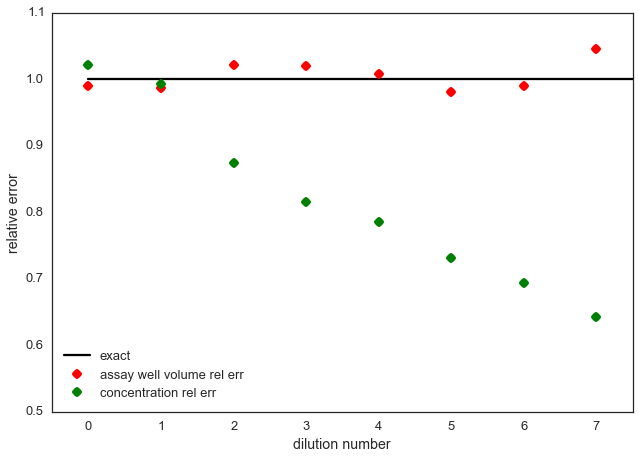

In [47]:
plt.plot([0,ndilutions], [1, 1], 'k-', range(ndilutions), assay_volumes / (compound_volume+mix_volume), 'ro', \
         range(ndilutions), assay_compound_concentrations / (ideal_concentrations*compound_volume/(compound_volume+mix_volume)), 'go');
plt.legend(['exact', 'assay well volume rel err', 'concentration rel err'], loc='lower left');
plt.xlabel('dilution number');
plt.ylabel('relative error');
plt.axis([-0.5, ndilutions - 0.5, 0.5, 1.1]);

In [48]:
def competitive_inhibition(substrate_concentration, inhibitor_concentration, enzyme_concentration, Ki, Km):
    V0_over_Vmax = substrate_concentration / (Km*(1 + inhibitor_concentration/Ki) + substrate_concentration)
    return V0_over_Vmax

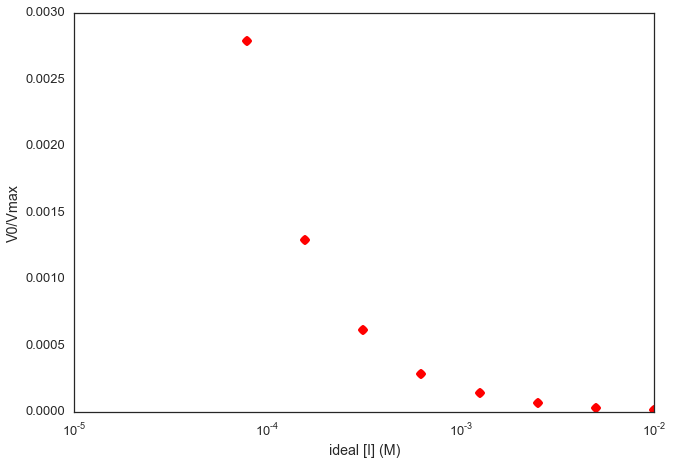

In [49]:
activity = numpy.zeros([ndilutions], numpy.float64)
for i in range(ndilutions):
    activity[i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)

plt.semilogx(ideal_concentrations, activity, 'ro');
plt.xlabel('ideal [I] (M)');
plt.ylabel('V0/Vmax');

What does this look like if we run many assay replicates?

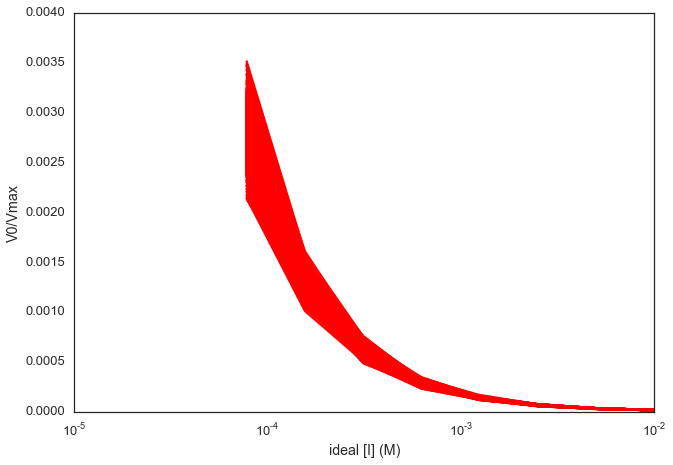

In [50]:
nreplicates = 1000
activity = numpy.zeros([nreplicates,ndilutions], numpy.float64)
for replicate in range(nreplicates):
    [actual_volumes, actual_concentrations] = DILUTE_ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
    [assay_volumes, assay_concentrations] = robot_dispense(compound_volume, mix_volume, actual_concentrations, tecan_genesis_pipetting_model)
    for i in range(ndilutions):
        activity[replicate,i] = competitive_inhibition(substrate_concentration, assay_concentrations[i], enzyme_concentration, true_Ki, Km)


plt.semilogx(ideal_concentrations, activity.transpose(), 'r-');
plt.xlabel('ideal [I] (M)');
plt.ylabel('V0/Vmax');

It's not hard to see that the IC50 will vary over a large range! Let's fit the IC50s to see.

[]

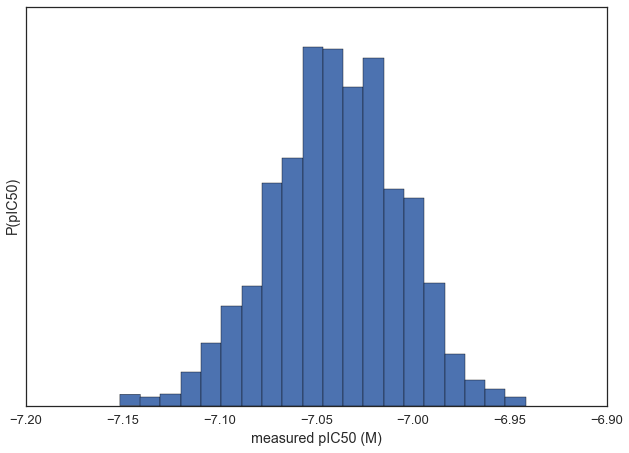

In [51]:
def fit_ic50(inhibitor_concentrations, activities):
    import numpy, scipy
    def objective(inhibitor_concentrations, Ki):
        activities = numpy.zeros([ndilutions], numpy.float64)
        for i in range(ndilutions):
            activities[i] = competitive_inhibition(substrate_concentration, inhibitor_concentrations[i], enzyme_concentration, Ki, Km)
        return activities
            
    Ki_guess = true_Ki
    import scipy.optimize
    [popt, pcov] = scipy.optimize.curve_fit(objective, inhibitor_concentrations, activities, p0=[Ki_guess])
    
    return popt[0]

IC50s_tips = numpy.zeros([nreplicates], numpy.float64)
for replicate in range(nreplicates):
    IC50s_tips[replicate] = fit_ic50(ideal_concentrations, activity[replicate,:])
pIC50s_tips = numpy.log10(IC50s_tips)
    
clf()
nhist = 20
hist(pIC50s_tips, nhist);
xlabel('measured pIC50 (M)');
ylabel('P(pIC50)');
gca().axes.get_yaxis().set_ticks([]); # turn off y ticks

The error won't be uniform across the whole Ki range, however. Let's characterize the standard error as a function of Ki.

In [52]:
def robot_IC50s(true_Ki):
    nreplicates = 1000
    IC50s = numpy.zeros([nreplicates], numpy.float64)
    for replicate in range(nreplicates):
        [actual_volumes, actual_concentrations] = DILUTE_ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
        [assay_volumes, assay_compound_concentrations] = robot_dispense(compound_volume, mix_volume, actual_concentrations, tecan_genesis_pipetting_model)
        activities = numpy.zeros([ndilutions], numpy.float64)
        for i in range(ndilutions):
            activities[i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)
        IC50s[replicate] = fit_ic50(ideal_concentrations, activities)
    return IC50s

pKis = numpy.array([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3], numpy.float64);
Kis = 10**pKis
nKis = len(pKis)
genesis_pIC50_bias = numpy.zeros([nKis], numpy.float64)
genesis_pIC50_CV = numpy.zeros([nKis], numpy.float64)
for (i, Ki) in enumerate(Kis):
    IC50s = robot_IC50s(Ki)    
    pIC50s = numpy.log10(IC50s)
    pKi = pKis[i]
    genesis_pIC50_bias[i] = pIC50s.mean() - pKi;
    genesis_pIC50_CV[i] = pIC50s.std() / abs(pIC50s.mean())    

We can plot the bias in the measured pIC50 values.

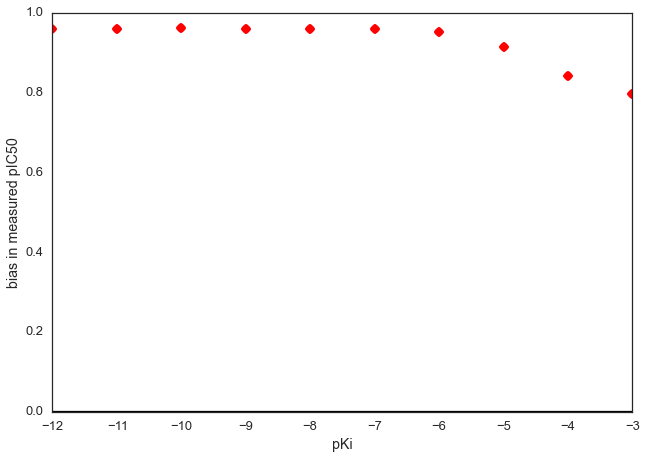

In [53]:
plot([pKis.min(), pKis.max()], [0, 0], 'k-', pKis, genesis_pIC50_bias, 'ro');
xlabel('pKi');
ylabel('bias in measured pIC50');

The CV is not so bad.

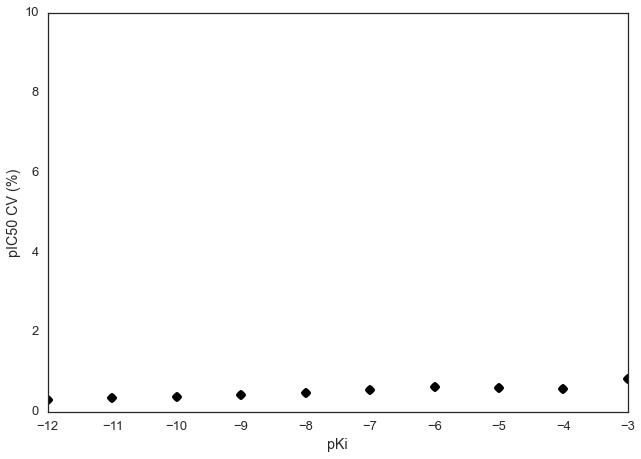

In [54]:
plot(pKis, genesis_pIC50_CV*100, 'ko');
xlabel('pKi');
ylabel('pIC50 CV (%)');
axis([pKis.min(), pKis.max(), 0, 10]);

### 3B. IC50s for the LabCyte Echo

How does a competitive inhibition look with the narrow dynamic range afforded by the LabCyte Echo?

In [55]:
[assay_volumes, assay_concentrations] = echo_assay_dispense(C0, mix_volume, backfill_volume, dispense_volumes)

nreplicates = 1000
actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = echo_assay_dispense(C0, mix_volume, backfill_volume, dispense_volumes)
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate

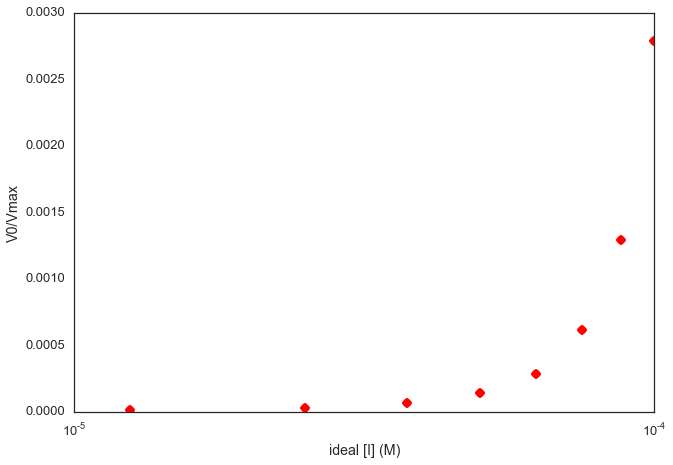

In [56]:
#echo
activity = numpy.zeros([ndilutions], numpy.float64)
for i in range(ndilutions):
    activity[i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)

# Plot V0/Vmax for a single realization,
semilogx(concentrations, activity, 'ro');
xlabel('ideal [I] (M)');
ylabel('V0/Vmax');

V0 only goes up to a maximum of 0.012, but we can still see some curvature that could give a decent fit to Michaelis-Menten for an IC50. Let's try a number of replicates to see how much variation there is between measurements.

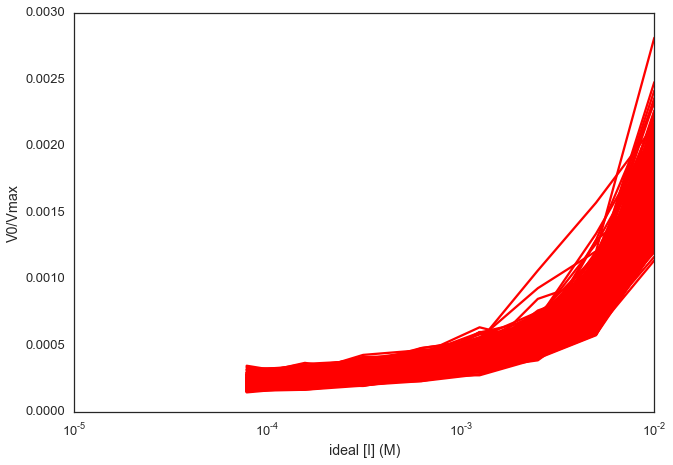

In [57]:
activity = numpy.zeros([nreplicates,ndilutions], numpy.float64)
for replicate in range(nreplicates):
    [assay_volumes, assay_compound_concentrations] = echo_assay_dispense(C0, mix_volume, backfill_volume, dispense_volumes)
    for i in range(ndilutions):
        activity[replicate,i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)

# Plot V0/Vmax for many measurements.
semilogx(ideal_concentrations, activity.transpose(), 'r-');
xlabel('ideal [I] (M)');
ylabel('V0/Vmax');

Transforming this into IC50s, we see there is a fair amount of error.


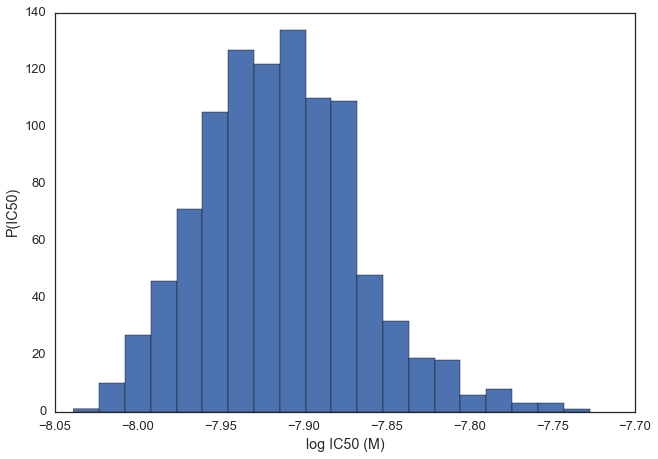

In [58]:
IC50s_echo = numpy.zeros([nreplicates], numpy.float64)
for replicate in range(nreplicates):
    IC50s_echo[replicate] = fit_ic50(ideal_concentrations, activity[replicate,:])

nhist = 20
hist(numpy.log10(IC50s_echo), nhist);
xlabel('log IC50 (M)');
ylabel('P(IC50)');

Let's characterize the error for the Echo assay as a function of Ki.

In [59]:
def echo_IC50s(true_Ki):
    nreplicates = 1000
    IC50s = numpy.zeros([nreplicates], numpy.float64)
    for replicate in range(nreplicates):
        [assay_volumes, assay_compound_concentrations] = echo_assay_dispense(C0, mix_volume, backfill_volume, dispense_volumes)
        activities = numpy.zeros([ndilutions], numpy.float64)
        for i in range(ndilutions):
            activities[i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)
        IC50s[replicate] = fit_ic50(ideal_concentrations, activities)
    return IC50s

# Run simulation of many experiments.
pKis = numpy.array([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3], numpy.float64);
Kis = 10**pKis
nKis = len(pKis)
echo_pIC50_bias = numpy.zeros([nKis], numpy.float64)
echo_pIC50_CV = numpy.zeros([nKis], numpy.float64)
for (i, Ki) in enumerate(Kis):
    IC50s = echo_IC50s(Ki)    
    pIC50s = numpy.log10(IC50s)
    pKi = pKis[i]
    echo_pIC50_bias[i] = pIC50s.mean() - pKi;
    echo_pIC50_CV[i] = pIC50s.std() / abs(pIC50s.mean())    

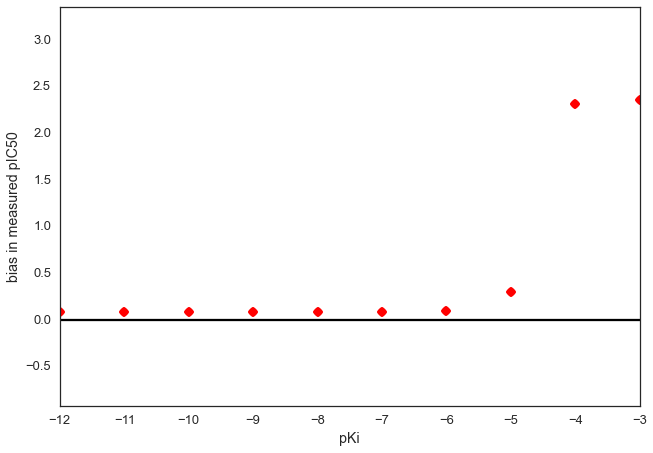

In [60]:
# Plot relative error in measured Ki values as a function of true Ki.
plot([pKis.min(), pKis.max()], [0, 0], 'k-', pKis, echo_pIC50_bias, 'ro');
xlabel('pKi');
ylabel('bias in measured pIC50');
axis([pKis.min(), pKis.max(), echo_pIC50_bias.min()-1, echo_pIC50_bias.max()+1]);

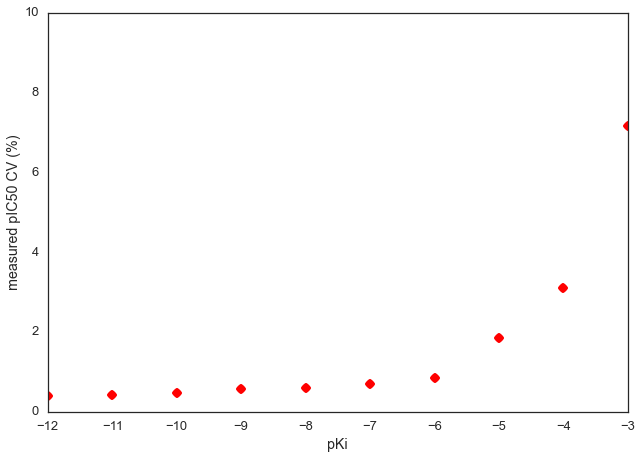

In [61]:
#Plot CV.
plot(pKis, echo_pIC50_CV*100, 'ro');
xlabel('pKi');
ylabel('measured pIC50 CV (%)');
axis([pKis.min(), pKis.max(), 0, 10]);

### 3C. Comparison of Tecan Genesis and LabCyte Echo modeled performance

What do we get when we plot the Tecan Genesis and Echo results against each other?

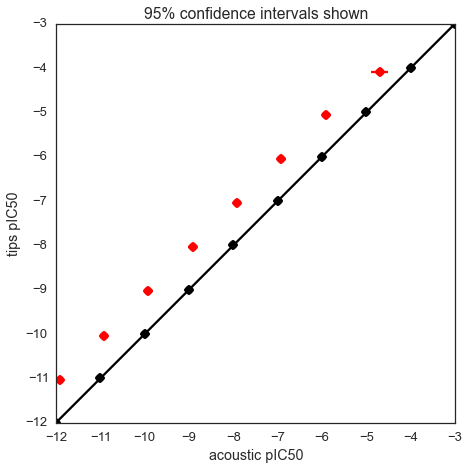

In [62]:
echo_pIC50_err = (echo_pIC50_CV*numpy.abs(pKis))
genesis_pIC50_err = (genesis_pIC50_CV*numpy.abs(pKis))

clf();
subplot(111, aspect='equal');
hold(True);
plot([pKis.min(), pKis.max()], [pKis.min(), pKis.max()], 'k-');
plot(pKis, pKis, 'ko');
errorbar(pKis + echo_pIC50_bias, pKis + genesis_pIC50_bias, xerr=2*echo_pIC50_err, yerr=2*genesis_pIC50_err, fmt='ro');
axis([pKis.min(), pKis.max(), pKis.min(), pKis.max()]);
xlabel('acoustic pIC50');
ylabel('tips pIC50');
title('95% confidence intervals shown');

In [63]:
# data from Fig 1 of Fregau et al.
echo_IC50s = numpy.array([0.064, 0.486, 0.003, 0.002, 0.007, 0.003, 0.004, 0.052, 0.01362, 0.207, 0.158, 0.01164, 0.00633, 0.00358]) * 1e-6 # M
genesis_IC50s = numpy.array([0.817, 3.03, 0.146, 0.553, 0.973, 0.778, 0.445, 0.17, 0.112, 14.4, 0.25, 0.049, 0.087, 0.152]) * 1e-6 # M

echo_pIC50s = numpy.log10(echo_IC50s);
genesis_pIC50s = numpy.log10(genesis_IC50s);

Let's add the error bars we modeled to see if the variation is sufficient to bring the two sets of data into agreement.

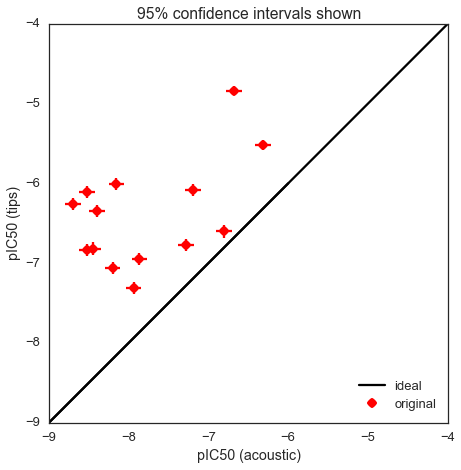

In [64]:
# Interpolate bias and CV for Echo and Genesis.
from scipy.interpolate import interp1d
echo_bias_interpolation = interp1d(pKis, echo_pIC50_bias);
echo_CV_interpolation = interp1d(pKis, echo_pIC50_CV);
genesis_bias_interpolation = interp1d(pKis, genesis_pIC50_bias);
genesis_CV_interpolation = interp1d(pKis, genesis_pIC50_CV);

# Compute error bars for Echo and Genesis.
echo_pIC50_err = (echo_CV_interpolation(echo_pIC50s)*numpy.abs(echo_pIC50s))
genesis_pIC50_err = (genesis_CV_interpolation(genesis_pIC50s)*numpy.abs(genesis_pIC50s))

# Plot with error bars.
figure();
subplot(111, aspect='equal');
hold(True);
plot([-9, -4], [-9, -4], 'k-');
errorbar(echo_pIC50s, genesis_pIC50s, xerr=2*echo_pIC50_err, yerr=2*genesis_pIC50_err, fmt='ro');
plot([-9, -6], [-9, -6], 'k-');
xlabel('pIC50 (acoustic)');
ylabel('pIC50 (tips)');
legend(['ideal', 'original'], loc='lower right');
title('95% confidence intervals shown');

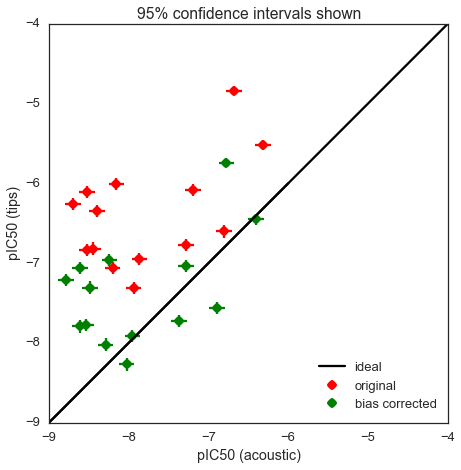

In [65]:
# Plot.
figure();
subplot(111, aspect='equal');
hold(True);
plot([-9, -4], [-9, -4], 'k-');
errorbar(echo_pIC50s, genesis_pIC50s, xerr=2*echo_pIC50_err, yerr=2*genesis_pIC50_err, fmt='ro');
errorbar(echo_pIC50s - echo_bias_interpolation(echo_pIC50s), genesis_pIC50s - genesis_bias_interpolation(genesis_pIC50s), xerr=2*echo_pIC50_err, yerr=2*genesis_pIC50_err, fmt='go');
plot([-9, -6], [-9, -6], 'k-');
xlabel('pIC50 (acoustic)');
ylabel('pIC50 (tips)');
legend(['ideal', 'original', 'bias corrected'], loc='lower right');
title('95% confidence intervals shown');

The assays are in much better agreement at this point, but it does not appear that the specified imprecision of the Tecan Genesis and Labcyte Echo are sufficient to explain the remaining discrepancies.

### 4. At the Chodera Lab we use the D300 for our direct dispensing needs!